# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

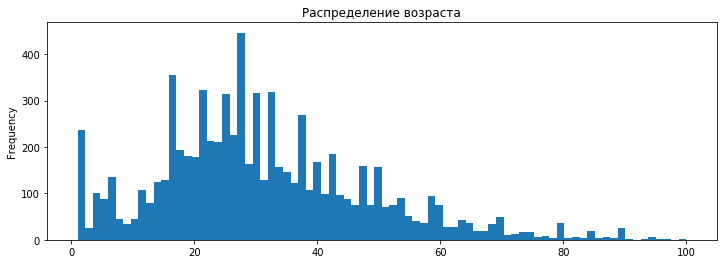

In [4]:
labels['real_age'].plot(kind = 'hist', figsize = (12,4), title = 'Распределение возраста', bins=80);

7591 фотографий/наблюдений в нашей выборке и основное количество приходится на возраст от 20-30. В принципе данные все распределены правильно и выглядит все адекватно без аномалий 

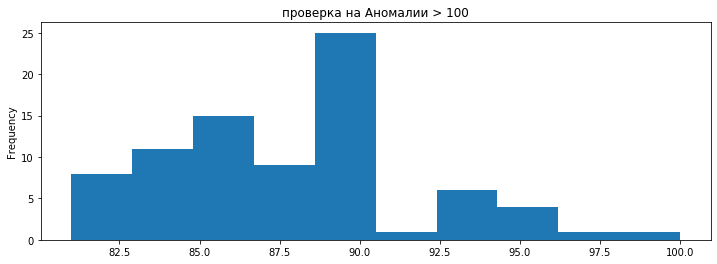

In [5]:
labels[labels['real_age'] > 80]['real_age'].plot(kind = 'hist', figsize = (12,4), title = 'проверка на Аномалии > 100');

Для просмотра аномалий - нету ли странных значений за 100 или чего-то необычного построили доп график и убедились ,что данные распределены нормально. И из долгожителей большинство сосредоточено около возраста 90

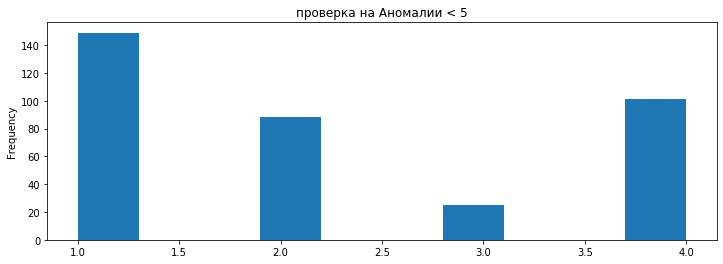

In [16]:
labels[labels['real_age'] < 5]['real_age'].plot(kind = 'hist', figsize = (12,4), title = 'проверка на Аномалии < 5');

Исходя из этого графика видно ,что младенцев и вправду очень большое количество в выборке ,если посмотреть на количество только от 1 до 5 ,то выходит уже примерно более 300 ,если смотреть на обозначение frequency ,отсюда получаем подтвреждение первого графика о том ,что здесь есть вполне неплохие отголоски биномиального распределения

In [23]:
labels = labels[labels['real_age']>90]

Found 13 validated image filenames.


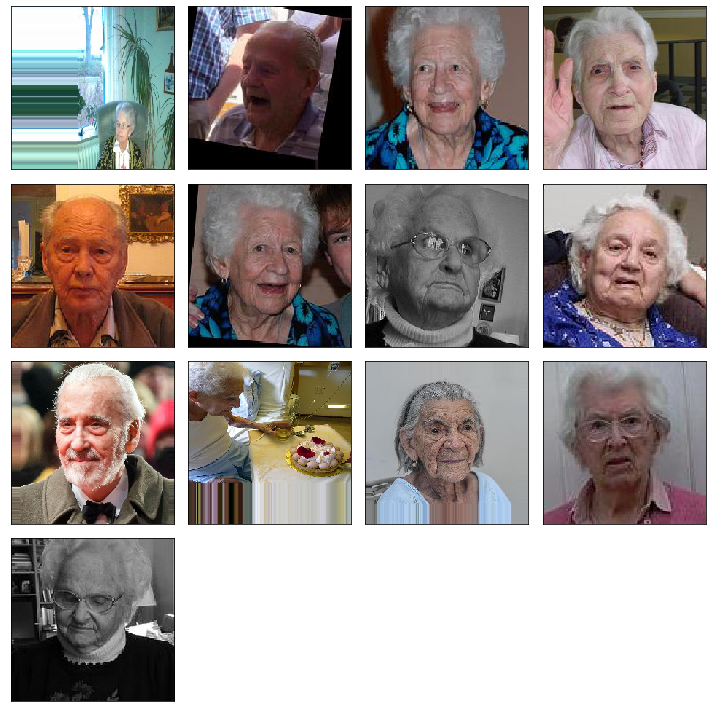

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=13,
        class_mode='raw',
        seed=12345)

import matplotlib.pyplot as plt

features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(13):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Я думаю ,что вид и качество не должны стремится к одному идеалу ,ибо например если взять сет ,где фотки все цветные и хорошего качества , а потом приходит фотография с плохим освещением и более "пиксельная" ,то модель будет однозначно работать хуже ,чем лучше , поэтому в идеале подобрать максимально охватывающую все возможные варианты выборку и если надо ,то сделать аугментацию в сторону ,где предположительно могут быть новые кейсы
<br>
<br>
3) Думаю вполне можно сделать флипы горизонтальные или вертикальные , так как уже на некоторых из этих фотографий видно ,что они повернуты в различные стороны 
<br>
4) Также на фотографиях заметен шум , например микрофон перекрывающий лицо или жевачка ,которая также закрывает лицо , можно также добавить случайные полупрозрачные линии , окружности 
<br>
5) У фотографий с черным фоном также можно поменять задний фон на другой цвет ,но сомнительный как по мне метод и возможно бесполезный
<br>
6) Также больше всего мне бы хотелось как объединение всех методов , сделать так ,чтобы основная масса аугментации приходилась именно на группу старше 60 лет , так как данных там совсем не много , а детей и людей среднего возраста и так достаточно ,и применяя аугментацию к ним - сделало бы только хуже
<br>
Также после того как удалось вывести группу пенсионеров кому за 90 , то увидел новый ряд проблем и искажений фотографий, например на самой первой из них стоит и самая большая проблема и отражающая все проблемы , так как , там качество плохое , размерность именно самого человека тоже очень маленькая относительно всей фотографии (больше похоже как будто комнату фоткали , а не бабушку) , по всему датасету сложно искать такие случаи и удалить их непросто будет , но это единственный для меня на данный момент способ борьбы с такого рода проблемой .Также как будто толи стояла выдержка , толи это уже один из способов аугментации применили к фотографии , так как там есть какие-то непонятные полосы слева , тоже самое замечается и на других фотографиях 

# 2. Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_test(path):
    labels_test = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels_test,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_gen_flow

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_gen_flow

def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

def create_model(input_shape):
    
    backbone = ResNet50(
                       input_shape = input_shape,
                       weights = 'imagenet',
                       include_top = False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/3
2020-09-16 14:10:57.586575: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-16 14:11:02.762792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 121s - loss: 283.5621 - mae: 12.0169 - val_loss: 792.1824 - val_mae: 23.1811
Epoch 2/3
356/356 - 43s - loss: 91.4011 - mae: 7.2079 - val_loss: 205.7610 - val_mae: 10.9355
Epoch 3/3
356/356 - 42s - loss: 59.5690 - mae: 5.9107 - val_loss: 84.0305 - val_mae: 6.8122
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 84.0305 - mae: 6.8122
Test MAE: 6.8122

```

# 3. Анализ обученной модели

Модель справилась достаточно просто с данной задачей , я даже не успел поменять колчество эпох на какое-то более достойное) Но тем не менее - модель и архитектура ResNet50 отлично справилась с задачей регрессии возраста, мне кажется ,что самое главное работая с CV это чтобы сэмплы имели максимально большой охват в выборке ,чтобы в будущем все некрашилось дико нестандартной вещью ,но по сути тоже самое , думаю что неплохо с этим помогает грамотная аугментация ,чтобы модель не переобучилась ,также как и градиентном бустинге не малую роль играет learning rate & loss function ,но в данном случае уже не будет такого большого разбега для learning rate 